# Document Summarization

Topic models permit the extraction of sophisticated, interpretable text features that can be
used in various ways to extract trading signals from large collections of documents. They
speed up the review of documents, help identify and cluster similar documents, and can be
annotated as a basis for predictive modeling. Applications include the identification of key
themes in company disclosures, or earnings call transcripts, customer reviews or contracts,
annotated using, for example, sentiment analysis or direct labeling with subsequent asset
returns.

The focus of this case study are as follows:
* Implement the LDA model for topic modeling
* Understand the data preparation (i.e. converting a pdf for NLP related problem)
* Visualisation of the topics

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1) 
* [3. Data Preparation](#2)
* [4.Model Construction and Training](#4)        
* [5.Visualization of results](#5) 
    * [5.1. Topic Visualization](#5.1) 
    * [5.2. Word Cloud](#5.2) 

<a id='0'></a>
# 1. Problem Definition

The goal of this project is to effectively discover common
topics among a large data set of earnings call transcripts
of publicly traded companies. Each transcript will be assigned to some number of topics, and the specific segments
of the transcript which address a given topic will hopefully
be specified as well. Thus, not only will the documents be
classified as covering some set of topics, but the documents
themselves will be partitioned into different sub-topics. This
work would be useful in improving the search of financial documents and serving users appropriate documents including those that, while not about a specific company, may be
highly relevant due to a shared industry or product. The
following sections discuss all major aspects of this task including data preprocessing and vizualisation.


<a id='1'></a>
# 2. Getting Started- Loading the data and python packages


<a id='1.1'></a>
## 2.1. Loading the python packages
For this case study we will extract the text from a pdf. Hence, a python library pdf-miner used for processing pdf into text format is used. Other thatn takes in the name of the pdf document, libraries for feature extraction and topic modeling are loaded. The libraries for the vizualisation will be loaded later. 

In [133]:
#Libraries for pdf conversion
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
import re
from io import StringIO

#Libraries for feature extraction and topic modeling
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

#Other libraries
import numpy as np
import pandas as pd

In [134]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

<a id='2'></a>
# 3. Data Preparation

The function defined below pulls out all characters from a pdf document except the images. The function simply takes in the name of the pdf document, extracts all characters from it and outputs the extracted texts as a python list of strings.

In [135]:
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text

The pdf is converted to text using the function defined above.

In [136]:
Document=convert_pdf_to_txt('10K.pdf')

In [137]:
f=open('Finance10k.txt','w')
f.write(Document)
f.close()
with open('Finance10k.txt') as f:
    clean_cont = f.read().splitlines()

Let us look at the raw document

In [138]:
clean_cont[1:15]

[' ',
 '',
 'SECURITIES AND EXCHANGE COMMISSION',
 ' ',
 '',
 'Washington, D.C. 20549',
 ' ',
 '',
 '\xa0',
 'FORM ',
 '\xa0',
 '',
 'QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF',
 ' ']

The text extracted from the pdf document contains uninformative characters which needs to be removed. These characters reduces the effectiveness of our models as they provide unnecessary count ratios. The function below uses a series of regex search and replace function as well as a list-comprehension to replace these characters with a blank space. The functions below were used for this process and the resulting document shown is seen to contain just alphanumeric characters

In [139]:
doc=[i.replace('\xe2\x80\x9c','') for i in clean_cont ]
doc=[i.replace('\xe2\x80\x9d','') for i in doc ]
doc=[i.replace('\xe2\x80\x99s','') for i in doc ]

docs = [x for x in doc if x != ' ']
docss = [x for x in docs if x != '']
financedoc=[re.sub("[^a-zA-Z]+", " ", s) for s in docss]

In [140]:
financedoc[1:15]

['SECURITIES AND EXCHANGE COMMISSION',
 'Washington D C ',
 ' ',
 'FORM ',
 ' ',
 'QUARTERLY REPORT PURSUANT TO SECTION OR d OF',
 'THE SECURITIES EXCHANGE ACT OF ',
 'For the quarterly period ended September ',
 'Commission file number ',
 ' ',
 ' ',
 'WELLS FARGO COMPANY ',
 ' Exact name of registrant as specified in its charter ',
 'Delaware ']

<a id='4'></a>
# 4. Model construction and training

The scikit-learn module CountVectorizer was used with minimal parameter tuning to represent the clean document as a DocumentTermMatrix. This is because modeling requires that strings be represented as integers. The CountVectorizer shows the number of times a word occurs in the list after stop-words were removed.
The document term matrix was formatted into a pandas dataframe to glance the dataset, shown below. This dataframe shows count of word-occurrence of each term in the document. 

In [141]:
vect=CountVectorizer(ngram_range=(1,1),stop_words='english')
fin=vect.fit_transform(financedoc)
pd.DataFrame(fin.toarray(),columns=vect.get_feature_names()).head(1)

,aa,aaa,abbot,ability,able,abs,absorb,absorbed,absorbing,abusive,...,years,yes,yield,yielding,yields,york,yrs,zealand,zero,zip
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This document term matrix was used as the input data to be used by the Latent Dirichlet Allocation algorithm for topic modeling. The algorithm was fitted to isolate five-distinct topic contexts as shown by the code below. This value can definitely be altered depending on the level of granularity one intends to obtain from the modeling.

In [142]:
lda=LatentDirichletAllocation(n_components=5)
lda.fit_transform(fin)
lda_dtf=lda.fit_transform(fin)

In [143]:
sorting=np.argsort(lda.components_)[:,::-1]
features=np.array(vect.get_feature_names())

The code below uses the mglearn library to display the top 10 words within each specific topic model. One could easily draw conclusions what each topic summarizes from the words presented.

In [144]:
import mglearn
mglearn.tools.print_topics(topics=range(5), feature_names=features,
sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
net           value         assets        million       loans         
mortgage      risk          billion       capital       total         
credit        fair          september     equity        securities    
balance       financial     quarter       contracts     commercial    
rate          income        months        debt          real          
loan          management    losses        securities    estate        
cash          credit        december      common        mortgage      
income        securities    liabilities   stock         sale          
loss          expense       trading       regulatory    consumer      
sheet         statements    net           term          backed        




From the result above, clearly Topic-0 has much to do with loan risk condition . Topic-4 talks about income from real estate and expenses on non interest things & some obligations. Each topic is different from each other. Topic 2 discusses about the tentative quarters and months related to assets values. Topic 1 talks about the equity, debt, stocks etc. which are the components of income statement. 

<a id='5'></a>
# 5. Vizualisation of Topics

<a id='5.1'></a>
## 5.1 Topics Visualization

Topic visualization facilitates the evaluation of topic quality using human judgment.
pyLDAvis is library that displays the global relationships between topics while also facilitating their
semantic evaluation by inspecting the terms most closely associated with each topic and,
inversely, the topics associated with each term. It also addresses the challenge that terms
that are frequent in a corpus tend to dominate the multinomial distribution over words that
define a topic. The PyldaVis library was used to visualize the topic models. 

In [145]:
from __future__ import  print_function
import pyLDAvis
import pyLDAvis.sklearn

In [146]:
zit=pyLDAvis.sklearn.prepare(lda,fin,vect)

In [ ]:
pyLDAvis.show(zit)


Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [18/Apr/2020 22:11:20] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2020 22:11:20] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2020 22:11:20] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [18/Apr/2020 22:11:20] "GET /LDAvis.js HTTP/1.1" 200 -


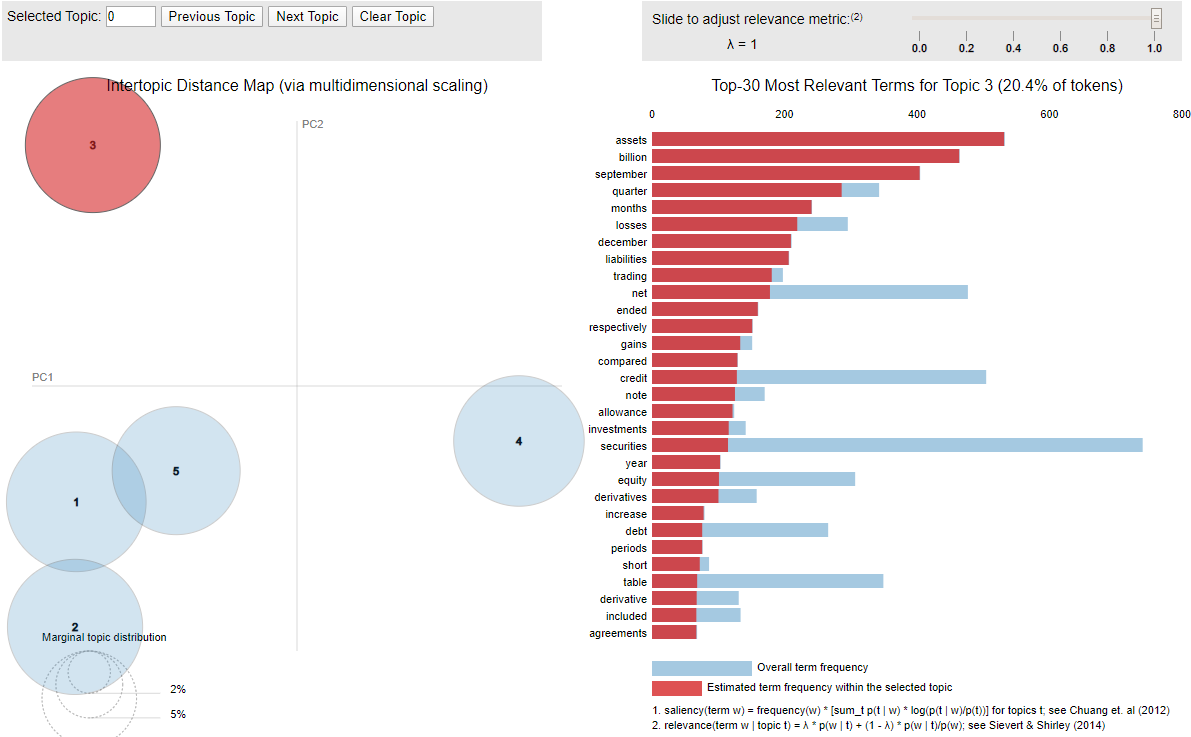

We notice how closely related Topic’s 1, 2 and 5 and also Topics 3 and 4 far from one another. These Topics (1, 2 and 5), 3 and 4 captures relatively distinct topics in the finance document and are those which should be observed more intricately as they would provide a broader view of the document when combined

<a id='5.2'></a>
## 5. WordCloud

A wordcloud was also generated for the entire legal document to note the most recurrent terms in the document as shown in the figure below. 

In [148]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

In [149]:
d = path.dirname(__name__)

In [150]:
text = open(path.join(d, 'Finance10k.txt')).read()

In [97]:
#raw_pic = np.array(Image.open(path.join(d, "legalpic.png")))

In [151]:
stopwords = set(STOPWORDS)
wc = WordCloud(background_color="black", max_words=2000, stopwords=stopwords)
wc.generate(text)

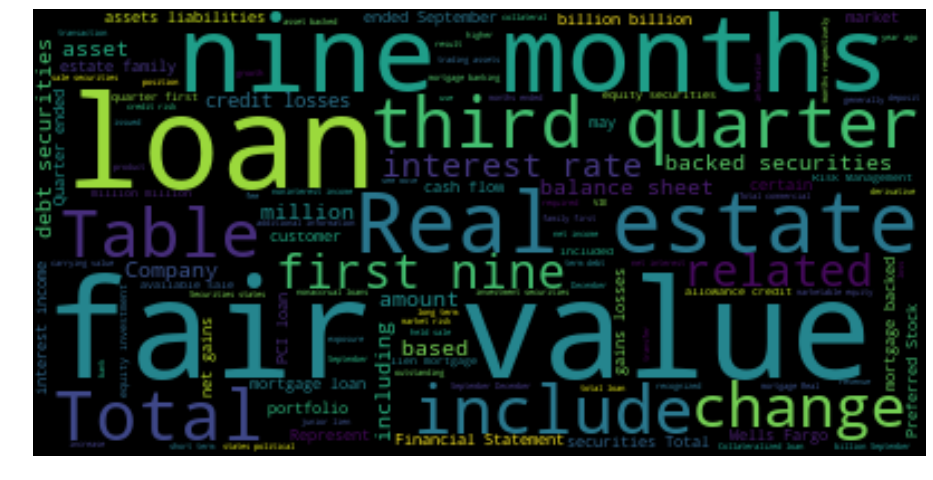

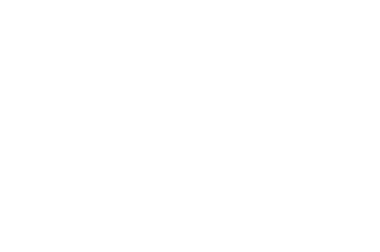

In [152]:
plt.figure(figsize=(16,13))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(raw_pic, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud generally agrees with the results from the topic modeling as words like : LOAN,REAL ESTATE, THIRD QUARTER,INTEREST RATE, CREDIT LOSSES etc are seen to be recurrent and hence bolder .

By integrating Topics’s 1, 3 and 4 obtained by the Latent Dirichlet Allocation modeling with the Word Cloud generated for the finance document, we can safely deduce that this document is a simple Third Quarter Financial Balance sheet with all credit and assets values in that quarter with respect to all assets values.


**Conclusion**

This project follows a simple approach to text extraction from documents in pdf, this project can be modified to reach in texts from a image file (.jpeg .png), such that topic modeling and summarization can be carried out on a snapshot of documents. The project shows how machine learning can be applied in the legal sector typically to provide document summary of subject-matter before hands.
A more practical use of this project is in text summarization on chapters of novels, textbooks etc of which it has been proven to work just right.

